### Season 24/25

### Mini League GW Ranks

In [1]:
import pandas as pd
import requests
from pprint import pprint
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\DENNIS\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Scrap data from FPL API

In [2]:
### base url for all fpl endpoints
base_url = 'https://fantasy.premierleague.com/api/'

### get data from the end point
r = requests.get(
    base_url +'bootstrap-static/'
).json()

pprint(r,indent=2,depth=1,compact=True)


{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 10905021}


In [3]:
### inspect data
r = requests.get(
    base_url+'leagues-classic/1456329/standings/'
).json()

pprint(r,indent=2,depth=1,compact=True)

{ 'last_updated_data': '2024-05-19T19:23:08Z',
  'league': {...},
  'new_entries': {...},
  'standings': {...}}


In [4]:
### write a function that outputs players when you enter a minileague code
### will need additional parameters for >50 teams
def get_season_rank(league_id):
    '''get mini league standings'''
    ### run get request
    r = requests.get(
        base_url+'leagues-classic/'+str(league_id)+'/standings/').json()
    df = pd.json_normalize(r['standings']['results'])
    return df

In [8]:
### pull out the league standings of a given mini league
managers_season = get_season_rank(239959).head(10) #1456329
managers_season

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name
0,89921626,60,Benjamin Safari,1,1,1,2492,1229678,Cheche Boyz
1,33496165,79,Marcos Gavvy,2,3,2,2483,4366721,Marcos FC
2,40175156,72,Denis Mwaniki,3,2,3,2474,5152606,Nene's Ballerz3.0
3,29526713,70,Elisha R. Okumu,4,4,4,2414,3953783,next_season
4,8125471,64,Mohamed Atta,5,5,5,2387,696414,##Fawzy Team ##
5,29789486,56,BRIAN BACHIA,6,6,6,2339,3976074,Mwana wa kaberia
6,8125465,50,John Mwalo,7,7,7,2319,1269571,Mwalo Mmoja
7,12917335,84,jack odhiambo,8,8,8,2310,1966424,The Treble
8,68317160,86,Abraham Musee,9,10,9,2305,8041535,Litu Fc
9,8960734,82,T-Minus Collo,10,9,10,2302,1391745,T_Minus FC


### Pull out each member of the league's gw points

In [9]:
def get_gw_points(manager_id):
    '''get gw points'''
    r = requests.get(
        base_url +'entry/'+str(manager_id)+'/history/'
    ).json()
    df = pd.json_normalize(r['current'])
    dt = pd.json_normalize(r['chips']).rename(columns={'name':'chip_used'})
    dft = df.merge(dt,on ='event' ,how='left')
    dft['manager_id'] = manager_id
    dft['chip_used'].fillna('none',inplace=True)


    return dft

In [11]:
### get managers' gw points across the season
league_gw_points = managers_season['entry'].progress_apply(get_gw_points) 

### combine results into a dataframe
league_gw_points = pd.concat(df for df in league_gw_points)

league_gw_points.head()

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


,event,points,total_points,rank,rank_sort,overall_rank,percentile_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,chip_used,time,manager_id
0,1,77,77,1221598,1261170,1221598,NaN,15,1000,0,0,13,none,NaN,1229678
1,2,78,155,34073,34609,23134,NaN,15,1004,1,0,16,none,NaN,1229678
2,3,51,206,2332672,2346648,28843,NaN,0,1010,1,0,6,none,NaN,1229678
3,4,69,275,6401346,6418508,122404,NaN,5,1015,1,0,5,none,NaN,1229678
4,5,48,323,3360208,3377763,117928,NaN,10,1015,1,0,4,none,NaN,1229678


In [20]:
### add their entry name & drop some cols
league_gw_points = league_gw_points[['event','manager_id','points','event_transfers','chip_used']].merge(managers_season[['entry','entry_name','player_name','rank_sort']],left_on = 'manager_id',right_on ='entry' ,how = 'left').reset_index().sort_values(by = ['event','points'],ascending = [True,False])
league_gw_points.head(10)

,index,event,manager_id,points,event_transfers,chip_used,entry,entry_name,player_name,rank_sort
0,0,1,4366721,84,0,none,4366721,Marcos FC,Marcos Gavvy,2
1,1,1,1229678,77,0,none,1229678,Cheche Boyz,Benjamin Safari,1
2,2,1,3976074,76,0,none,3976074,Mwana wa kaberia,BRIAN BACHIA,6
3,3,1,1269571,76,0,none,1269571,Mwalo Mmoja,John Mwalo,7
4,4,1,5152606,75,0,none,5152606,Nene's Ballerz3.0,Denis Mwaniki,3
5,5,1,3953783,73,0,none,3953783,next_season,Elisha R. Okumu,4
6,6,1,1391745,73,0,none,1391745,T_Minus FC,T-Minus Collo,10
7,7,1,1966424,72,0,none,1966424,The Treble,jack odhiambo,8
8,8,1,696414,70,0,none,696414,##Fawzy Team ##,Mohamed Atta,5
9,9,1,8041535,42,0,none,8041535,Litu Fc,Abraham Musee,9


In [21]:
### filter top 5

top_managers = managers_season.head()

top_managers

,id,event_total,player_name,rank,last_rank,rank_sort,total,entry,entry_name
0,89921626,60,Benjamin Safari,1,1,1,2492,1229678,Cheche Boyz
1,33496165,79,Marcos Gavvy,2,3,2,2483,4366721,Marcos FC
2,40175156,72,Denis Mwaniki,3,2,3,2474,5152606,Nene's Ballerz3.0
3,29526713,70,Elisha R. Okumu,4,4,4,2414,3953783,next_season
4,8125471,64,Mohamed Atta,5,5,5,2387,696414,##Fawzy Team ##


In [22]:
### top 5 managers' GW performances
top_managers_perf = league_gw_points[league_gw_points['manager_id'].isin(top_managers['entry'])] 
top_managers_perf.head(10)

,index,event,manager_id,points,event_transfers,chip_used,entry,entry_name,player_name,rank_sort
0,0,1,4366721,84,0,none,4366721,Marcos FC,Marcos Gavvy,2
1,1,1,1229678,77,0,none,1229678,Cheche Boyz,Benjamin Safari,1
4,4,1,5152606,75,0,none,5152606,Nene's Ballerz3.0,Denis Mwaniki,3
5,5,1,3953783,73,0,none,3953783,next_season,Elisha R. Okumu,4
8,8,1,696414,70,0,none,696414,##Fawzy Team ##,Mohamed Atta,5
10,10,2,1229678,78,1,none,1229678,Cheche Boyz,Benjamin Safari,1
14,14,2,5152606,49,1,none,5152606,Nene's Ballerz3.0,Denis Mwaniki,3
16,16,2,3953783,48,0,none,3953783,next_season,Elisha R. Okumu,4
17,17,2,696414,48,1,none,696414,##Fawzy Team ##,Mohamed Atta,5
19,19,2,4366721,42,0,none,4366721,Marcos FC,Marcos Gavvy,2


C:\Users\DENNIS\AppData\Local\Temp\ipykernel_34928\3671886686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_managers_perf['entry_name'] = pd.Categorical(


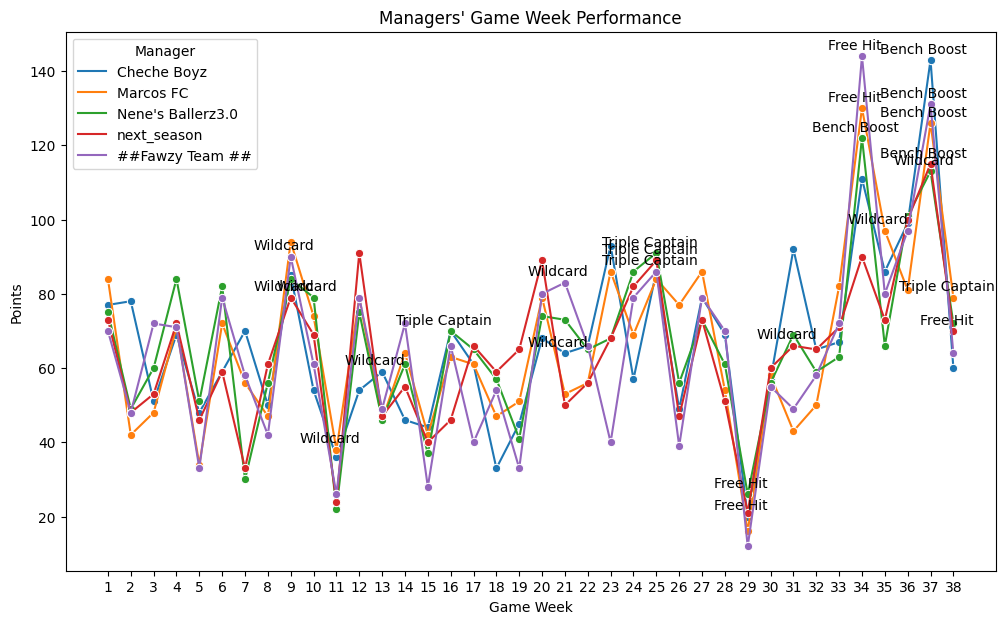

In [28]:



# Plot each manager's GW rank & points across the season
plt.figure(figsize=(12, 7))

# Line plot with hue by 'entry_name'
ax = sns.lineplot(data=top_managers_perf, x='event', y='points', hue='entry_name', marker='o')

# Sort top managers by rank_sort
sorted_top_mgers = top_managers_perf.sort_values('rank_sort')

# Ensure the list of managers is unique
unq_sorted_tp_mgers = sorted_top_mgers['entry_name'].unique()

# Reorder league gw points based on ranks
top_managers_perf['entry_name'] = pd.Categorical(
    top_managers_perf['entry_name'],
    categories=unq_sorted_tp_mgers, ordered=True
)

# Plot xticks for each GW
plt.xticks(ticks=top_managers_perf['event'].unique(), labels=top_managers_perf['event'].unique())

# Annotate chip usage
chip_events = {'Wildcard': 'wildcard', 'Triple Captain': '3xc', 'Free Hit': 'freehit', 'Bench Boost': 'bboost'}
for chip_name, chip_event in chip_events.items():
    chip_event_data = top_managers_perf[top_managers_perf['chip_used'] == chip_event]
    for i, row in chip_event_data.iterrows():
        ax.annotate(chip_name, (row['event'], row['points']), textcoords="offset points", xytext=(-5, 5), ha='center')

# Add labels
ax.set_title("Managers' Game Week Performance")
ax.set_ylabel('Points')
ax.set_xlabel('Game Week')

# Sort legend
handles, labels = ax.get_legend_handles_labels()

# Create a dictionary to avoid duplicates
unique_labels = {}
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels[label] = handle

sorted_labels = [label for label in unq_sorted_tp_mgers if label in unique_labels]
sorted_handles = [unique_labels[label] for label in sorted_labels]

ax.legend(sorted_handles, sorted_labels, title='Manager')

# Show plot
plt.show()